In [12]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from matplotlib.pyplot import figure
from matplotlib import patches

import nilearn
from nilearn.datasets import fetch_spm_auditory
from nilearn import image
from nilearn import masking
from nilearn import plotting
import pandas as pd

from os.path import join as opj
import json
# from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast, Normalize12
#tpm_img ='/home/ubuntu/Documents/MATLAB/spm12/tpm/TPM.nii' # normalization template

# from nipype.algorithms.modelgen import SpecifySPMModel
# from nipype.interfaces.utility import Function, IdentityInterface
# from nipype.interfaces.io import SelectFiles, DataSink
# from nipype import Workflow, Node
# #from bids.layout import BIDSLayout
# from nipype.algorithms.misc import Gunzip

import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel

from nilearn.reporting import get_clusters_table
from nilearn import maskers

from matplotlib import pyplot as plt

from nilearn.reporting import get_clusters_table
from nilearn import maskers
from nilearn import input_data


/Users/juliagarciacornet/opt/anaconda3/envs/Neuroimatge/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [19]:
def Act_Rrest (data_folder,subject_code,events_):
    for i in  subject_code:
        subject_folder='/sub-xp'
        String_contrinuation1='/func/sub-xp'
        String_contrinuation2='_task-eegfmriNF_bold.nii.gz'
        subject_codee=str(i)
    
        subject_data=data_folder+subject_folder+subject_codee+String_contrinuation1+subject_codee+String_contrinuation2
        
        fmri_img = nib.load(subject_data)
        mean_img = image.mean_img(fmri_img) #media de los time points
        mask = masking.compute_epi_mask(mean_img)
        fmri_img = image.clean_img(fmri_img, standardize=False)
        fmri_img = image.smooth_img(fmri_img, 5.)
        
        if i == subject_code[0]:
            del events_['stim_file']
            events=events_.replace({'Task-NF':'Task'}) 
        
        tr = 2  # repetition time of MRI scans is 5 seconds
        n_scans = fmri_img.shape[3]  # the acquisition comprises 210 scans
        frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times
        
        hrf_model = 'spm'
        X1 = make_first_level_design_matrix(frame_times, events, drift_model= "Cosine",
                                    hrf_model=hrf_model)
        
        fmri_glm = FirstLevelModel(signal_scaling=False, mask_img=mask, minimize_memory=False)
        fmri_glm = fmri_glm.fit(fmri_img, design_matrices=X1)
        
        z_map = fmri_glm.compute_contrast('Task- Rest') # els rois son els punts que mes canvien en el temps comparant task amb el rest
        
        
        plotting.plot_stat_map(z_map, bg_img=mean_img, threshold=3.1, title=subject_codee)
        
        
        
        table = get_clusters_table(z_map, stat_threshold=3.1,
                           cluster_threshold=20).set_index('Cluster ID', drop=True)
        print(table.head())

        # get the 4 largest clusters' max x, y, and z coordinates
        coords = table.loc[range(1,5), ['X', 'Y', 'Z']].values
        print(coords)

        # extract time series from each coordinate
        masker = input_data.NiftiSpheresMasker(coords)
        real_timeseries = masker.fit_transform(fmri_img)
        # The predicted time series was also extracted with GLM, it is useful to assess the quality of the model fit.
        predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])

        
        # colors for each of the clusters
        colors = ['blue', 'navy', 'purple', 'magenta']
        # plot the time series and corresponding locations
        fig1, axs1 = plt.subplots(2, 4)
        for i in range(0, 4):
            # plotting time series
            axs1[0, i].set_title('Cluster peak {}\n'.format(coords[i]))
            axs1[0, i].plot(real_timeseries[:, i], c=colors[i], lw=2)
            axs1[0, i].plot(predicted_timeseries[:, i], c='r', ls='--', lw=2)
            axs1[0, i].set_xlabel('Time')
            axs1[0, i].set_ylabel('Signal intensity', labelpad=0)
            
            # plotting image below the time series
            roi_img = plotting.plot_stat_map(
                z_map, cut_coords=[coords[i][2]], threshold=3.1, figure=fig1,
                axes=axs1[1, i], display_mode='z', colorbar=False, bg_img=mean_img)
            roi_img.add_markers([coords[i]], colors[i], 300)
        fig1.set_size_inches(24, 14)

                    X          Y          Z  Peak Stat Cluster Size (mm3)
Cluster ID                                                               
1          -32.520330 -20.197223  47.529446   7.659410                470
1a         -18.657965 -20.550283  47.357632   5.607381                   
2           56.097026 -39.564884  41.392382   7.092174               2229
2a          44.140904 -40.032112  37.143435   5.599653                   
2b          53.858889 -50.143255  42.458114   5.283053                   
[[-32.52032956 -20.1972231   47.5294461 ]
 [ 56.09702616 -39.56488356  41.39238235]
 [-13.0639691  -79.38444285 -20.03361337]
 [-31.66406559 -62.40282136  43.43638642]]
                    X           Y          Z  Peak Stat Cluster Size (mm3)
Cluster ID                                                                
1           12.390302  -76.773868  58.529329   9.626595                329
2          -13.515761 -106.630609   6.506523   9.012841                863
2a         -2

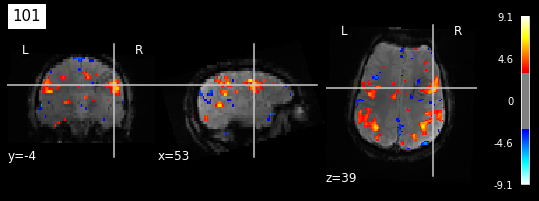

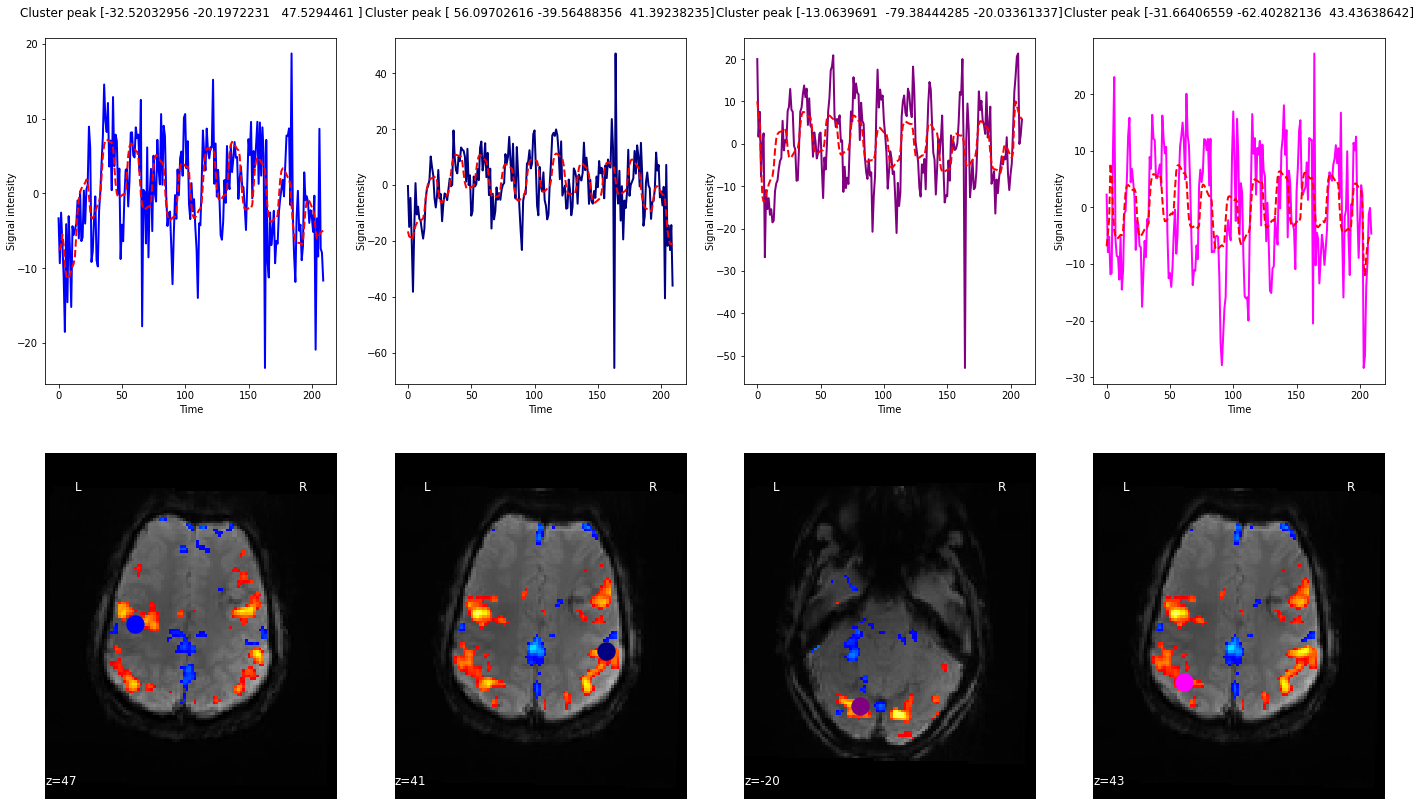

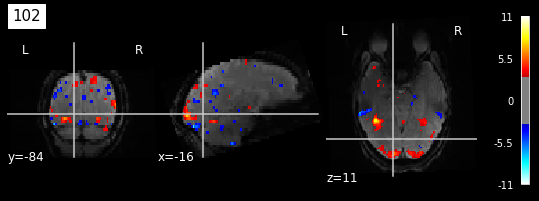

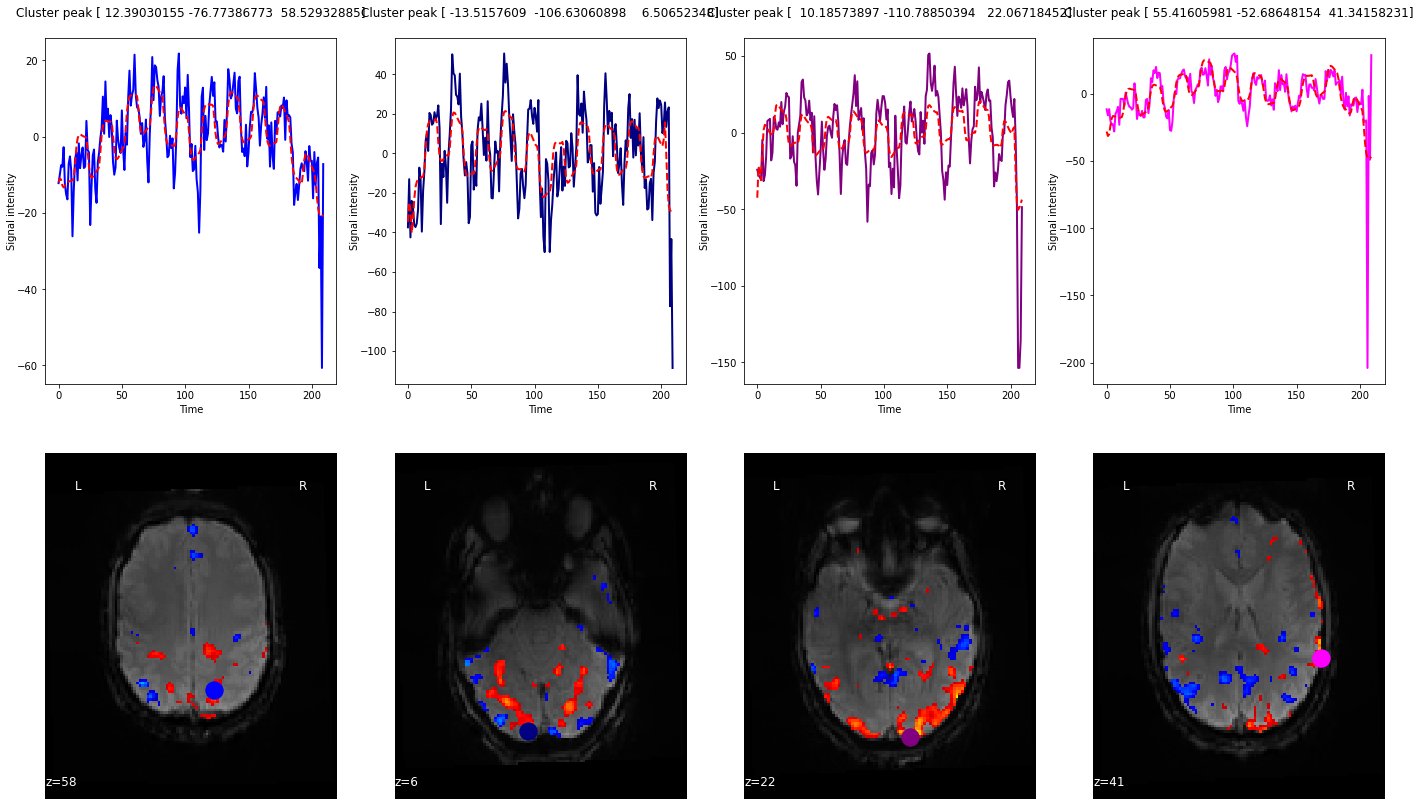

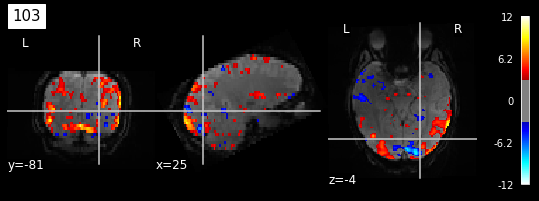

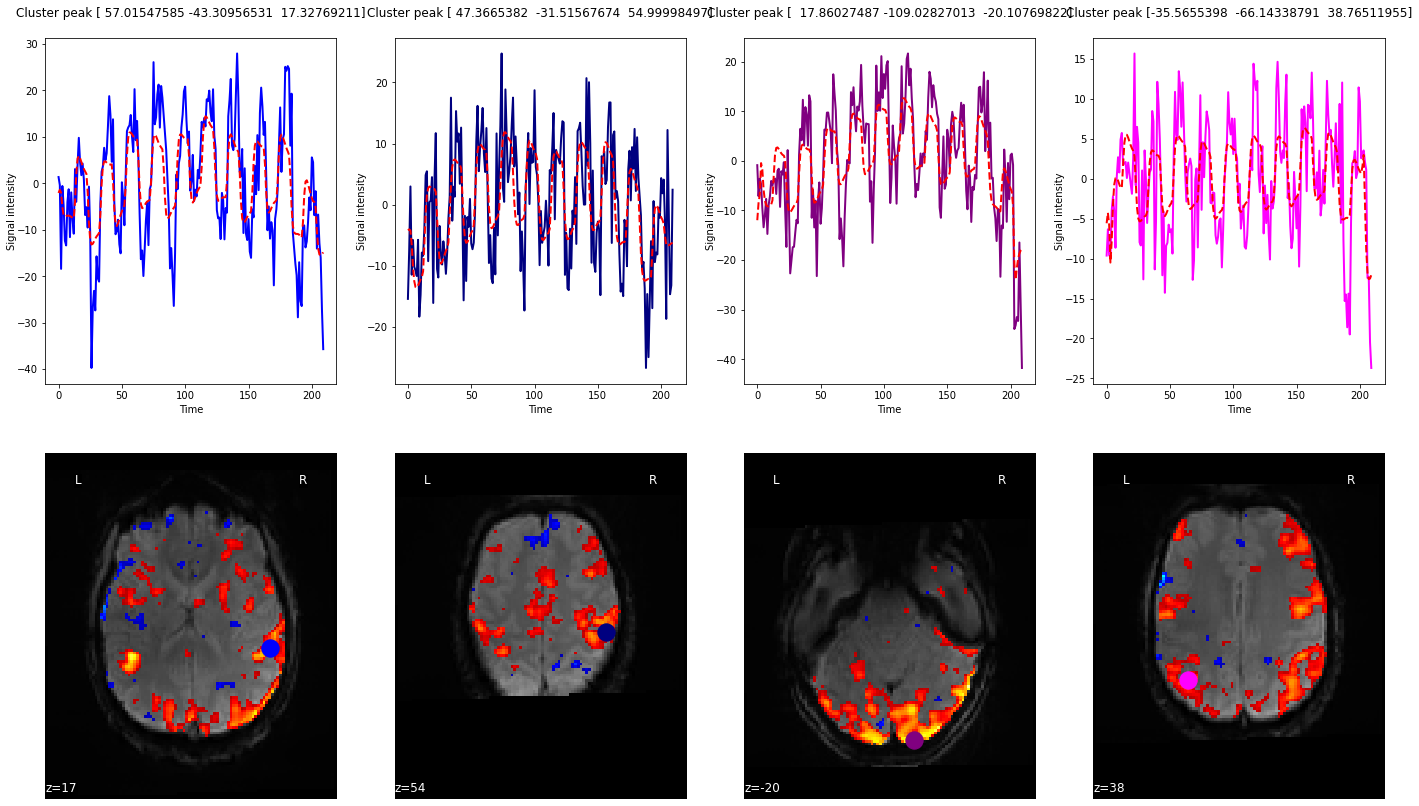

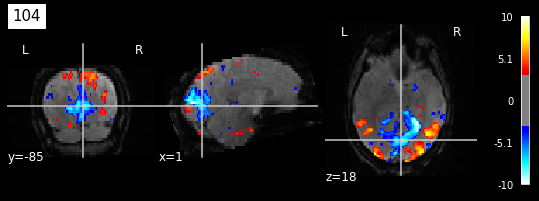

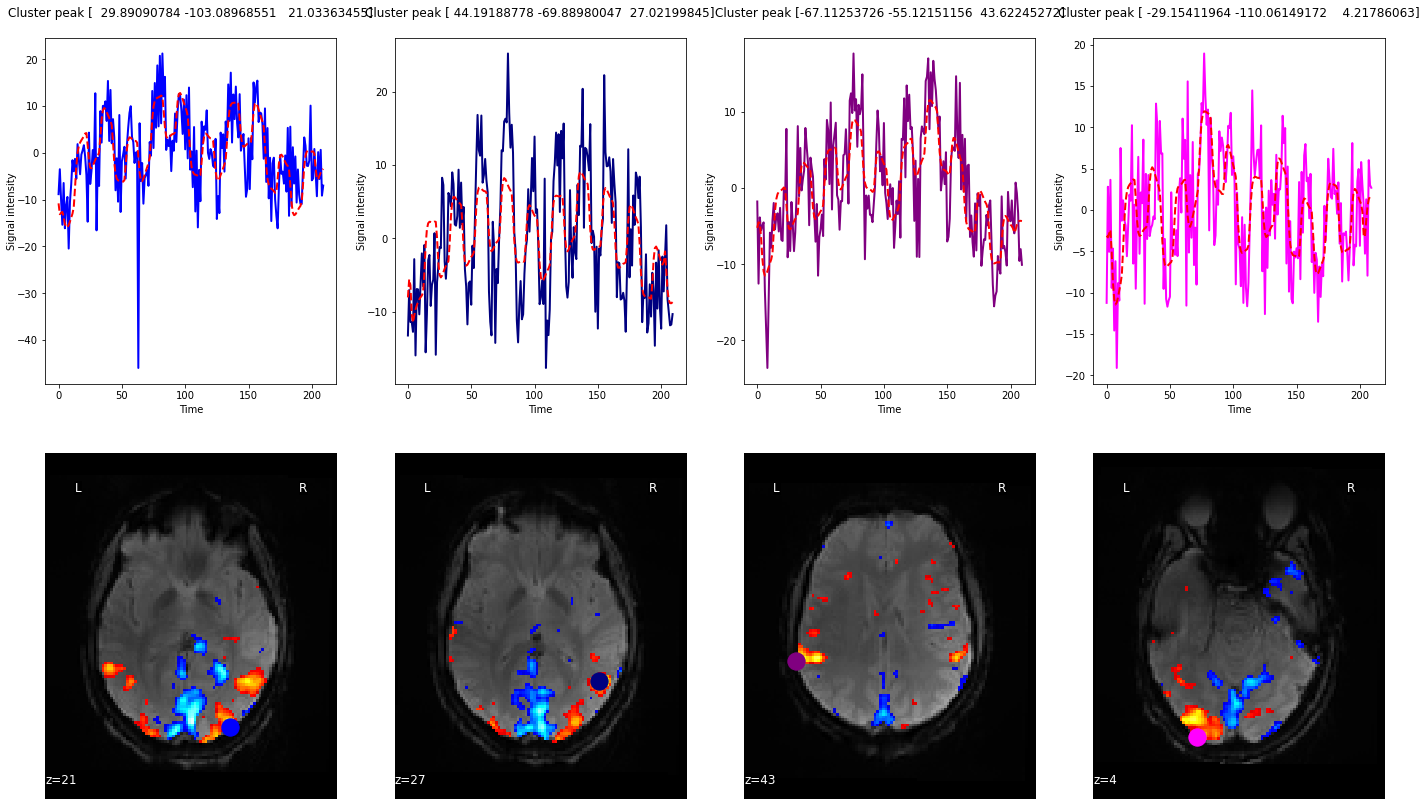

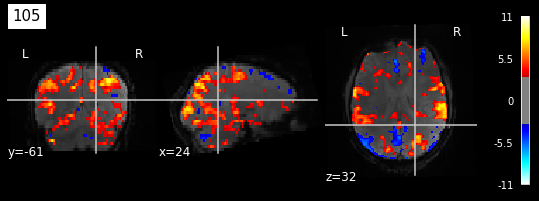

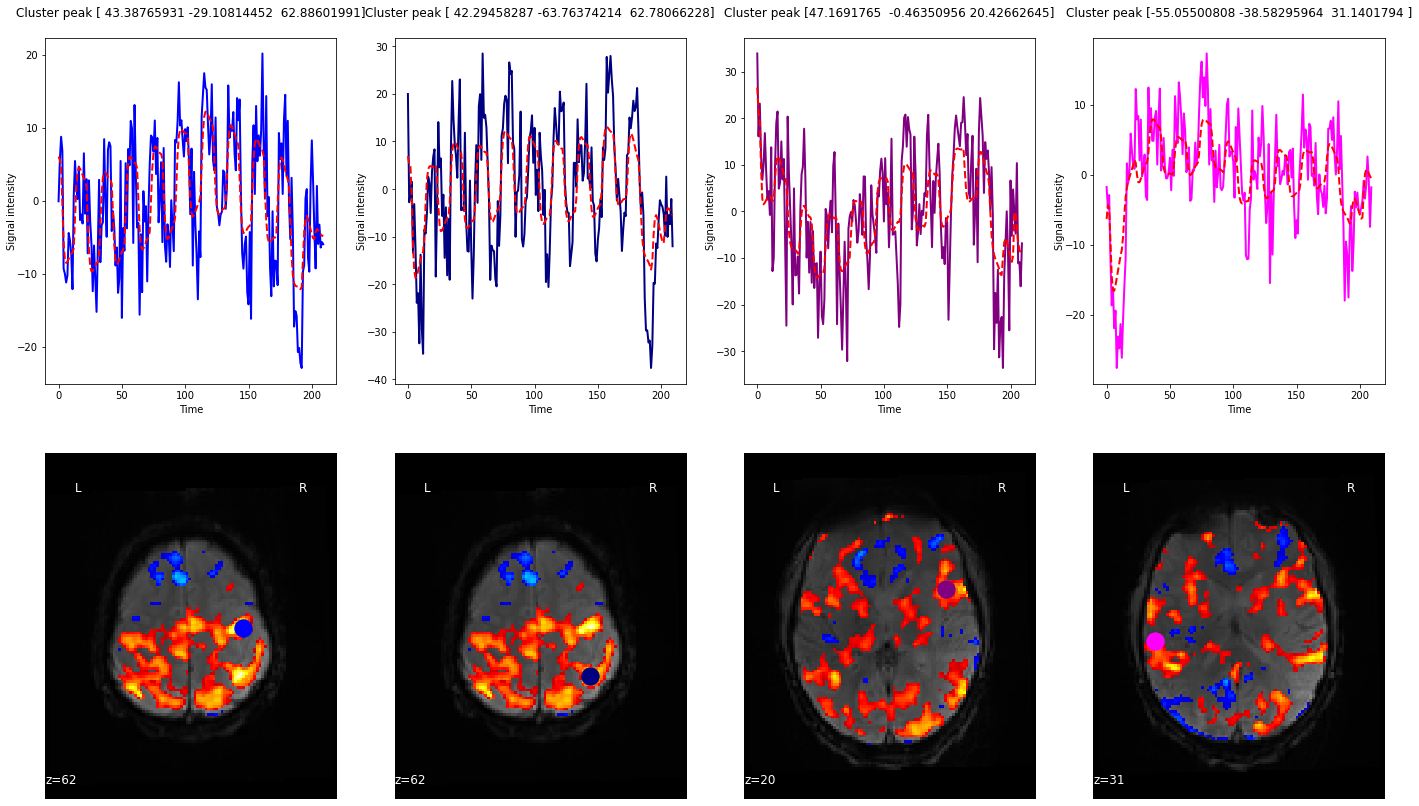

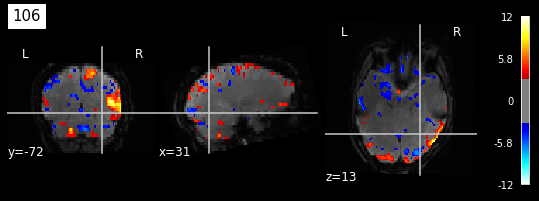

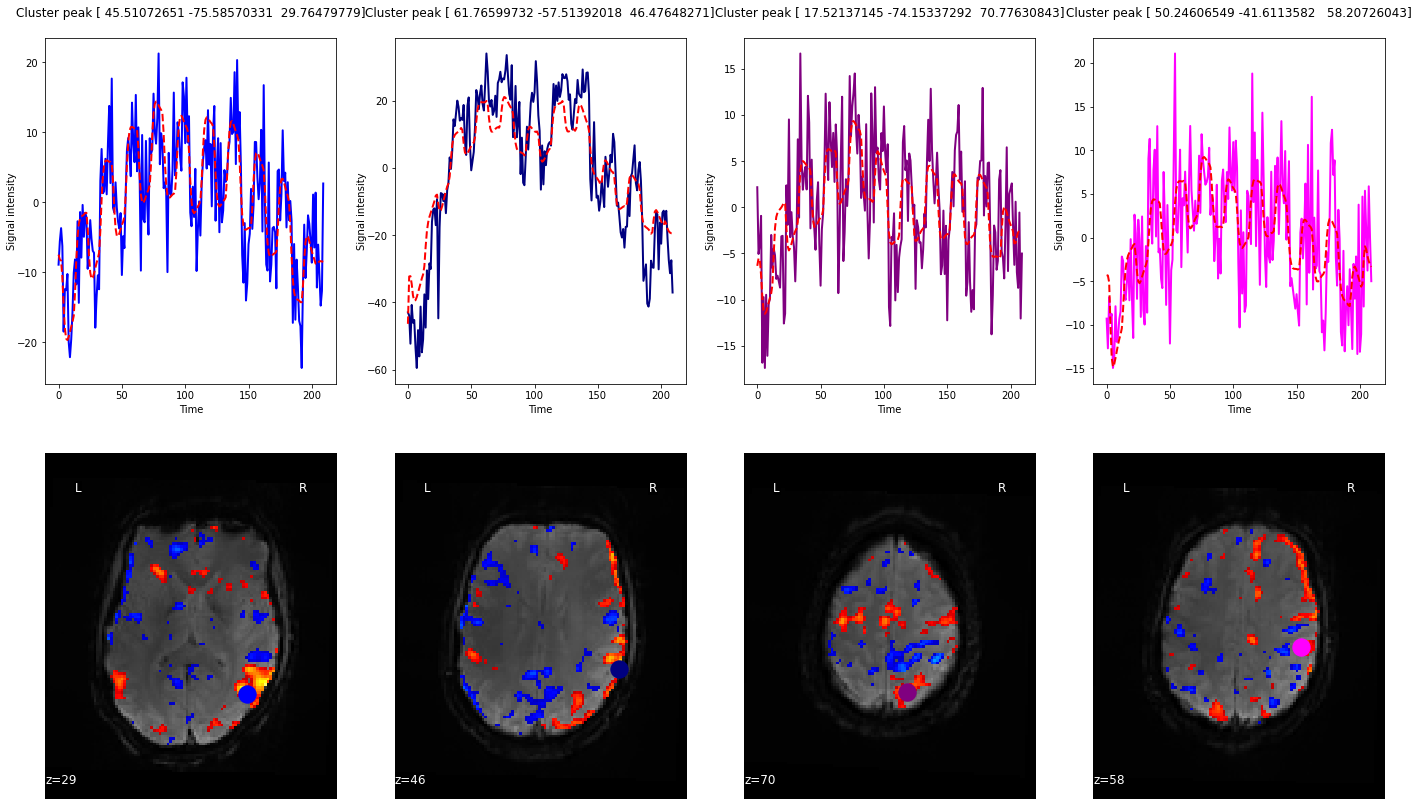

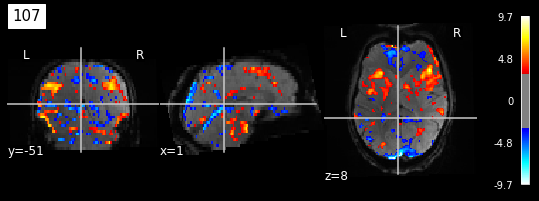

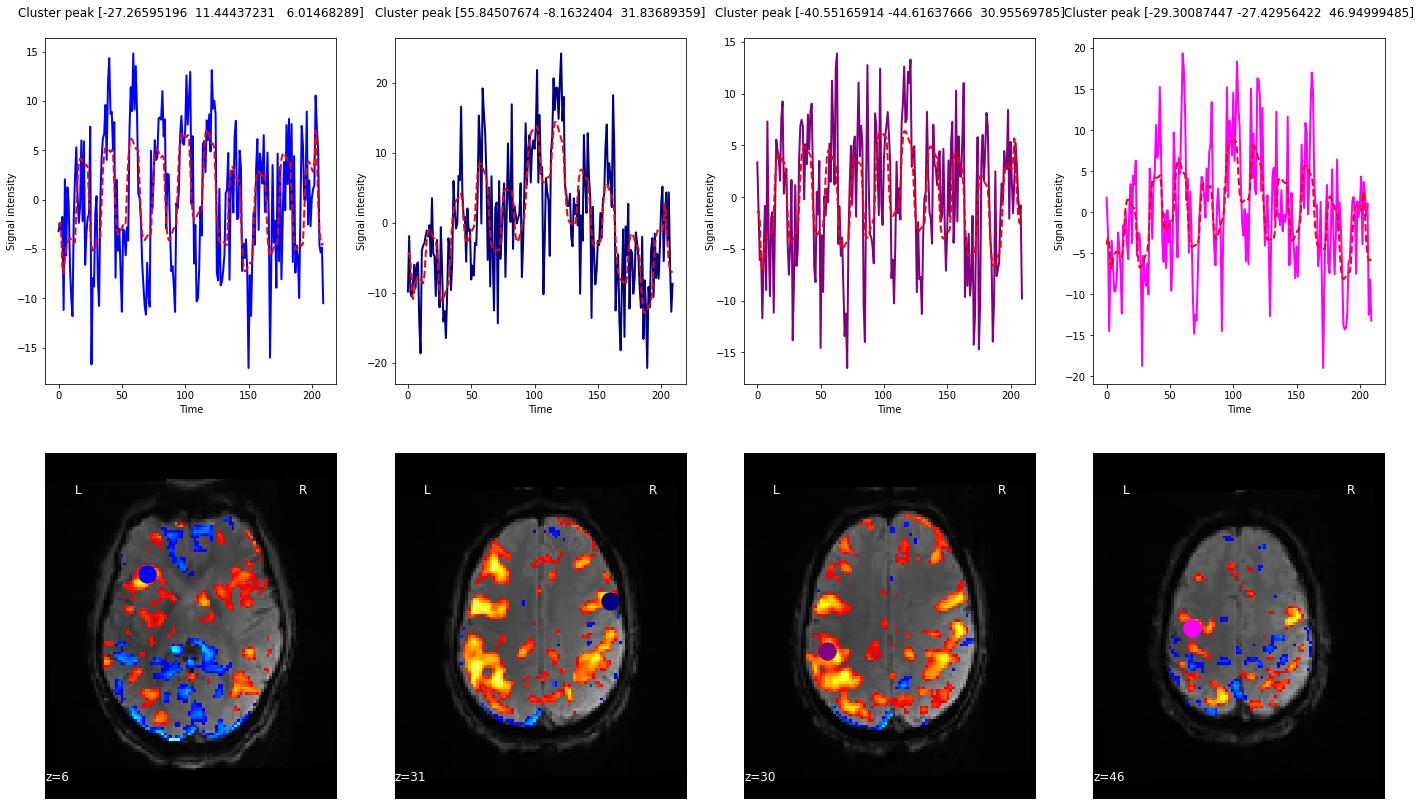

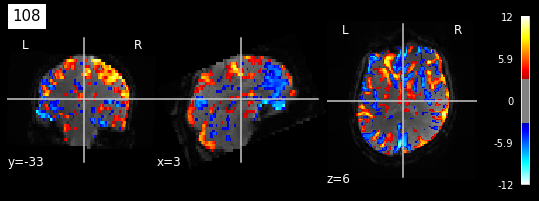

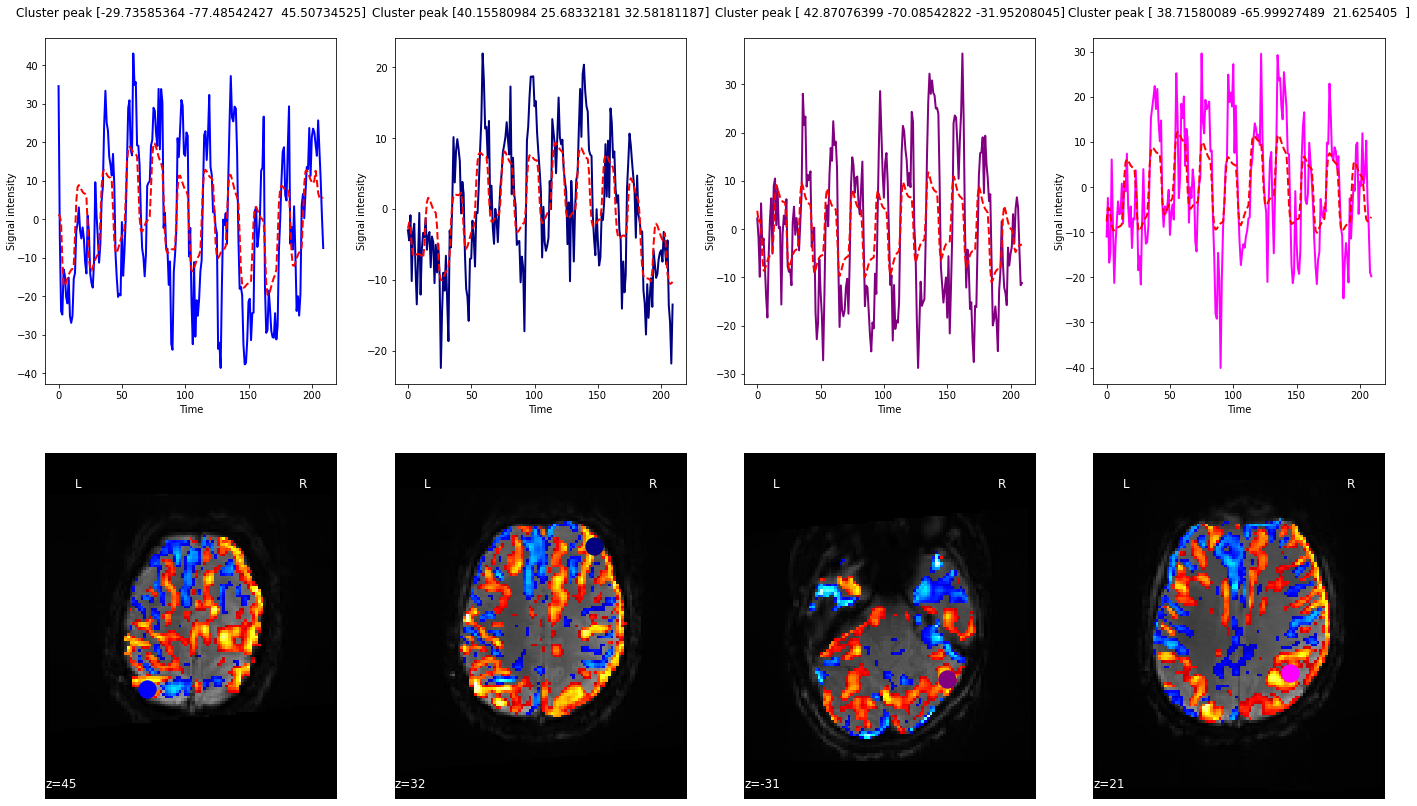

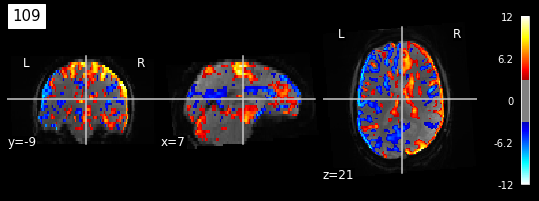

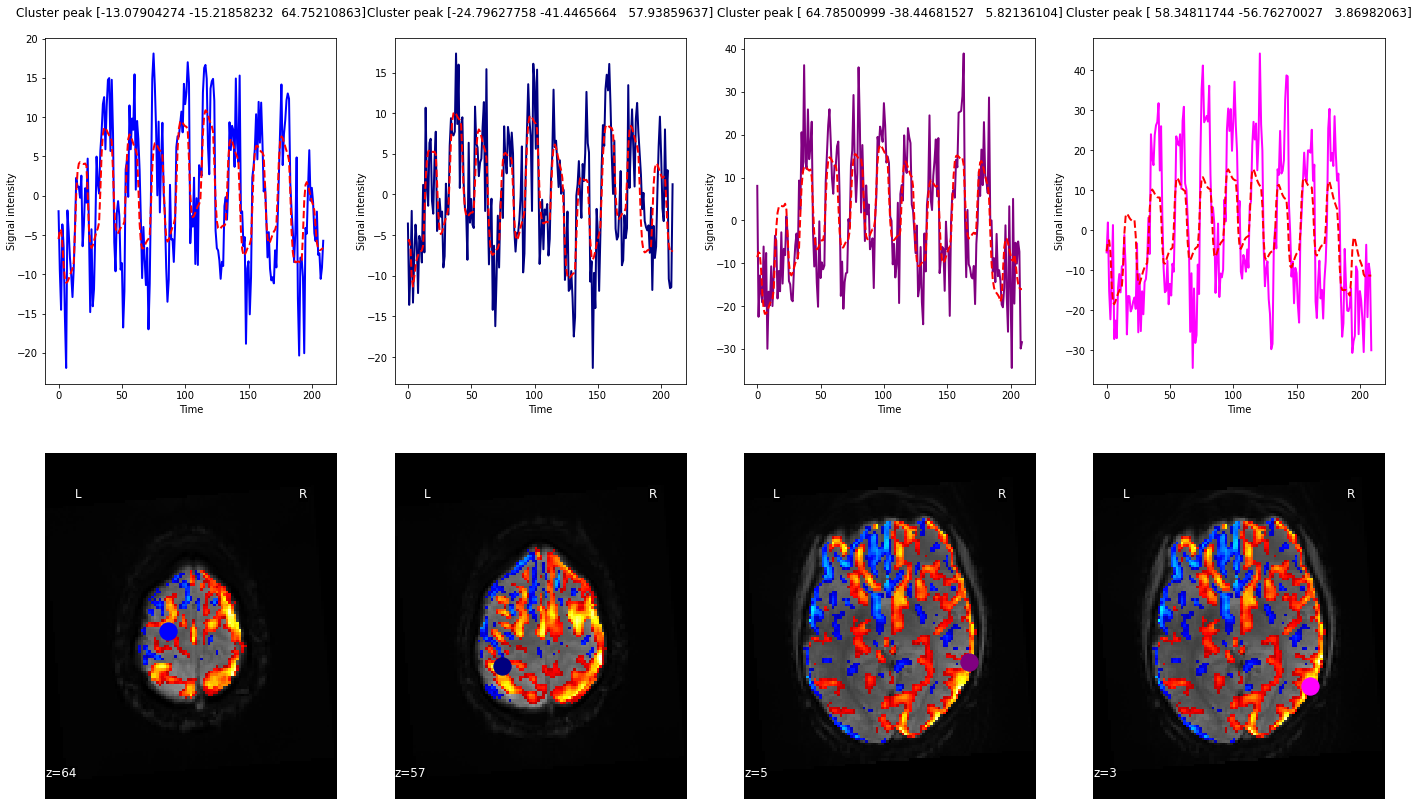

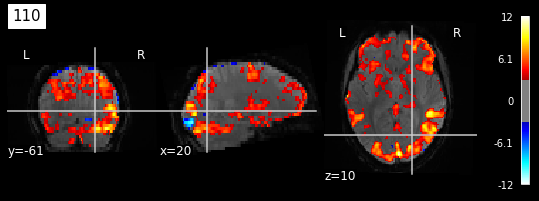

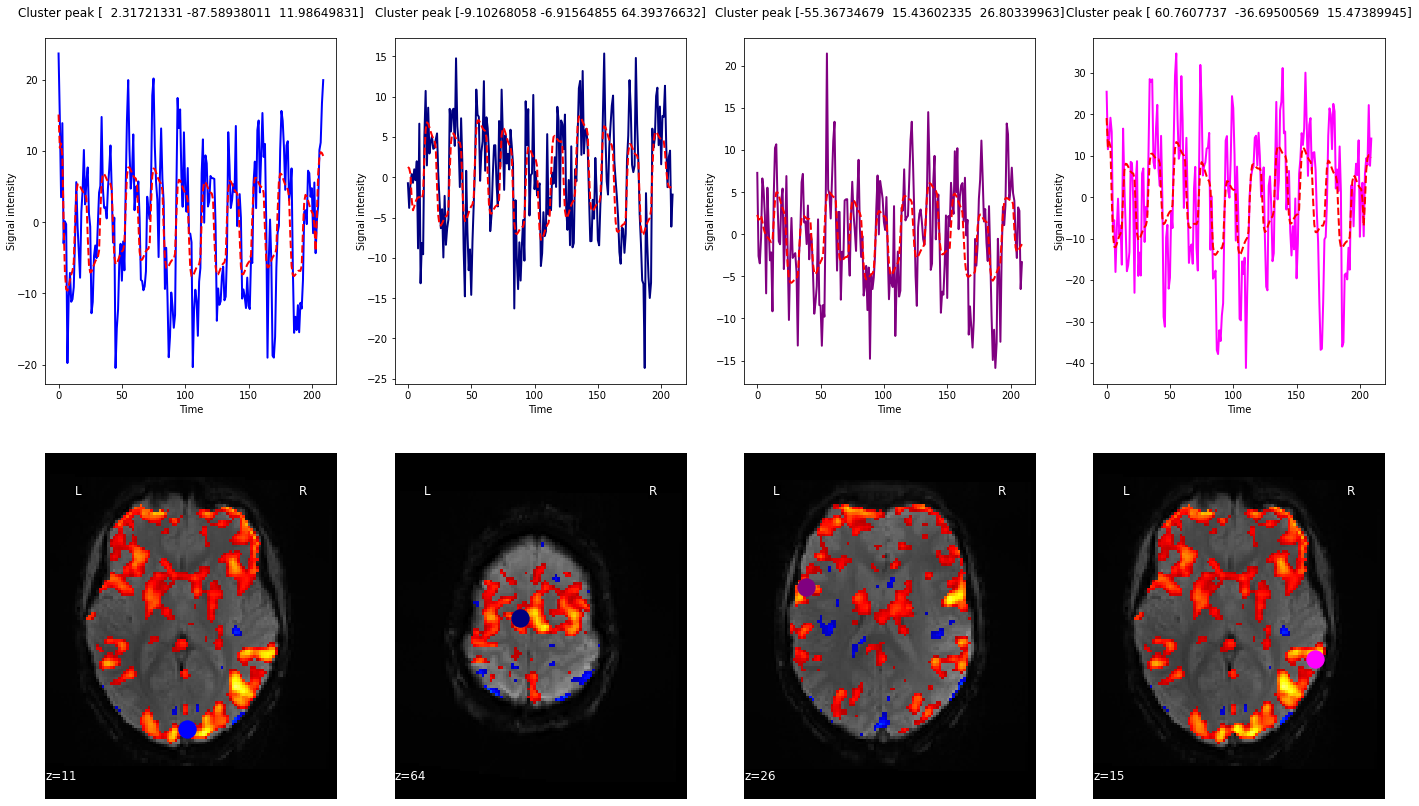

In [20]:
data_folder = '/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project'
subject_code=[101,102,103,104,105,106,107,108,109,110]
events_ = pd.read_table('/Users/juliagarciacornet/Desktop/Q4/Neuroimatge/project/task-eegfmriNF_events.tsv')

Act_Rrest (data_folder,subject_code,events_)